In [2]:
# ! pip install pandasql
# !sudo apt update 
# !sudo apt-get install texlive-xetex
# !sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended cm-super

In [3]:
import pandas as pd
from pandasql import sqldf
import matplotlib.pyplot as plt
import matplotlib

# matplotlib.rcParams['text.usetex'] = True
plt.rc('text.latex', preamble=r'\usepackage{underscore}')
default_backend = matplotlib.get_backend()

In [4]:
# from google.colab import drive
# drive.mount("/content/gdrive")

In [5]:
# resultsgraphs='/content/gdrive/MyDrive/cylon/generic_patterns_results'
resultsgraphs='/home/niranda/Desktop/results'
cylon='Anon'  #  'Cylon'

In [12]:
import numpy as np


def plot(data, out_file, title, just_show, colors=None):
    if not just_show:
        matplotlib.use("pgf")
        matplotlib.rcParams.update({
            "pgf.texsystem": "xelatex",
            'font.family': 'serif',
            'text.usetex': True,
            'pgf.rcfonts': False,
        })
    else:
        matplotlib.use(default_backend)

    ax = data.plot(x="world", loglog=True, xticks=data['world'], xlabel='parallelism', ylabel='time (ms)',
                   title=title, color=colors, marker='.')

    def scientific(x, pos):
        return f'{x}'
    from matplotlib.ticker import FuncFormatter

    scientific_formatter = FuncFormatter(scientific)
    ax.xaxis.set_major_formatter(scientific_formatter)

    if just_show:
        plt.show()

    if not just_show:
        plt.savefig(out_file)


def process_scalar(cy, mod, dask, pandas_, title, out_file, rows, just_show=False):
    cylon_df = pd.read_csv(cy, comment='#')
    modin_df = pd.read_csv(mod, comment='#')
    dask_df = pd.read_csv(dask, comment='#')
    pd_df = pd.read_csv(pandas_, comment='#')

    cylon_avg = sqldf(
        f"SELECT world, avg(time) as avg FROM cylon_df WHERE rows={rows} GROUP BY world", locals())
    modin_avg = sqldf(
        f"SELECT world, avg(time) as avg FROM modin_df WHERE rows={rows} GROUP BY world", locals())
    dask_avg = sqldf(
        f"SELECT world, avg(time) as avg FROM dask_df WHERE rows={rows} GROUP BY world", locals())

    data = sqldf(f"""SELECT cy.world, cy.avg AS {cylon}, md.avg AS modin, da.avg as dask
        FROM cylon_avg cy JOIN modin_avg md ON cy.world = md.world
        JOIN dask_avg da ON da.world = cy.world""", locals())

    pd_avg = sqldf(
        f"SELECT world, avg(time) as avg FROM pd_df WHERE rows={rows} GROUP BY world", locals())
    l = [None for _ in range(len(data))]
    l[0] = pd_avg['avg'][0]
    data['pandas'] = l

    plot(data, out_file, title, just_show, colors={
         cylon: 'royalblue', 'modin': 'orange', 'dask': 'green', 'pandas': 'maroon'})


def process_join(cy, mod, dask, pandas_, title, out_file, rows, just_show=False):
    cylon_df = pd.read_csv(cy, comment='#')
    modin_df = pd.read_csv(mod, comment='#')
    dask_df = pd.read_csv(dask, comment='#')

    cylon_hash_avg = sqldf(
        f"SELECT world, avg(time) as avg FROM cylon_df WHERE rows={rows} AND tag like '%hash%' GROUP BY world", locals())
    cylon_sort_avg = sqldf(
        f"SELECT world, avg(time) as avg FROM cylon_df WHERE rows={rows} AND tag like '%sort%' GROUP BY world", locals())
    modin_avg = sqldf(
        f"SELECT world, avg(time) as avg FROM modin_df WHERE rows={rows} GROUP BY world", locals())
    dask_avg = sqldf(
        f"SELECT world, avg(time) as avg FROM dask_df WHERE rows={rows} GROUP BY world", locals())

    if len(modin_avg):
        data = sqldf(f"""SELECT cy.world, cy.avg AS {cylon}_hash, cys.avg as {cylon}_sort, md.avg AS modin, da.avg as dask 
          FROM cylon_hash_avg cy 
          JOIN cylon_sort_avg cys ON cy.world = cys.world
          JOIN modin_avg md ON cy.world = md.world
          JOIN dask_avg da ON da.world = cy.world
          """, locals())
    else:
        data = sqldf(f"""SELECT cy.world, cy.avg AS {cylon}_hash, cys.avg as {cylon}_sort, da.avg as dask 
          FROM cylon_hash_avg cy 
          JOIN cylon_sort_avg cys ON cy.world = cys.world
          JOIN dask_avg da ON da.world = cy.world
          """, locals())

    pd_df = pd.read_csv(pandas_, comment='#')
    pd_avg = sqldf(
        f"SELECT world, avg(time) as avg FROM pd_df WHERE rows={rows} GROUP BY world", locals())
    l = [None for _ in range(len(data))]
    l[0] = pd_avg['avg'][0]
    data['pandas'] = l
    plot(data, out_file, title, just_show, colors={
         f'{cylon}_sort': 'royalblue', f'{cylon}_hash': 'cornflowerblue', 'modin': 'orange', 'dask': 'green', 'pandas': 'maroon'})


def process_groupby(cy, mod, dask, pandas_, title, out_file, rows, just_show=False):
    cylon_df = pd.read_csv(cy, comment='#')
    modin_df = pd.read_csv(mod, comment='#')
    dask_df = pd.read_csv(dask, comment='#')

    cylon_hash_avg = sqldf(
        f"SELECT world, avg(time) as avg FROM cylon_df WHERE rows={rows} AND tag like '%hash%u=0.9%' GROUP BY world", locals())
    cylon_sort_avg = sqldf(
        f"SELECT world, avg(time) as avg FROM cylon_df WHERE rows={rows} AND tag like '%mapred_hash%u=0.9%' GROUP BY world", locals())
    modin_avg = sqldf(
        f"SELECT world, avg(time) as avg FROM modin_df WHERE rows={rows} GROUP BY world", locals())
    dask_avg = sqldf(
        f"SELECT world, avg(time) as avg FROM dask_df WHERE rows={rows} GROUP BY world", locals())

    data = sqldf(f"""SELECT cy.world, cy.avg AS {cylon}_hash, cys.avg as {cylon}_mapred_hash, md.avg AS modin, da.avg as dask 
        FROM cylon_hash_avg cy 
        JOIN cylon_sort_avg cys ON cy.world = cys.world
        JOIN modin_avg md ON cy.world = md.world
        JOIN dask_avg da ON da.world = cy.world
        """, locals())

    pd_df = pd.read_csv(pandas_, comment='#')
    pd_avg = sqldf(
        f"SELECT world, avg(time) as avg FROM pd_df WHERE rows={rows} GROUP BY world", locals())
    l = [None for _ in range(len(data))]
    l[0] = pd_avg['avg'][0]
    data['pandas'] = l

    plot(data, out_file, title, just_show, colors={
         f'{cylon}_hash': 'royalblue', f'{cylon}_mapred_hash': 'cornflowerblue', 'modin': 'orange', 'dask': 'green', 'pandas': 'maroon'})


def process_groupby_cylon(cy, title, out_file, rows, just_show=False):
    cylon_df = pd.read_csv(cy, comment='#')

    cylon_hash_09_avg = sqldf(
        f"SELECT world, avg(time) as avg FROM cylon_df WHERE rows={rows} AND  tag like '%hash%u=0.9%' GROUP BY world", locals())
    cylon_mapred_09_avg = sqldf(
        f"SELECT world, avg(time) as avg FROM cylon_df WHERE rows={rows} AND  tag like '%mapred_hash%u=0.9%' GROUP BY world", locals())
    cylon_hash_1e_avg = sqldf(
        f"SELECT world, avg(time) as avg FROM cylon_df WHERE rows={rows} AND  tag like '%hash%u=1e-05%' GROUP BY world", locals())
    cylon_mapred_1e_avg = sqldf(
        f"SELECT world, avg(time) as avg FROM cylon_df WHERE rows={rows} AND  tag like '%mapred_hash%u=1e-05%' GROUP BY world", locals())

    data = sqldf("""SELECT cy09.world, cy09.avg AS hash_09, cymap.avg as mapred_09, cy1e.avg AS hash_1e_05, cymap1e.avg as mapred_1e_05 
        FROM cylon_hash_09_avg cy09 
        JOIN cylon_mapred_09_avg cymap ON cy09.world = cymap.world
        JOIN cylon_hash_1e_avg cy1e ON cy09.world = cy1e.world
        JOIN cylon_mapred_1e_avg cymap1e ON cy09.world = cymap1e.world
        """, locals())

    data = data.rename(columns={'hash_09': 'hash C=0.9', 'hash_1e_05': 'hash C=1e-5',
                       'mapred_09': 'mapred C=0.9', 'mapred_1e_05': 'mapred C=1e-5'})
    # print(data)
    plot(data, out_file, title, just_show, colors={
         'hash C=0.9': 'tab:blue', 'hash C=1e-5': 'tab:cyan', 'mapred C=0.9': 'tab:red', 'mapred C=1e-5': 'tab:pink'})


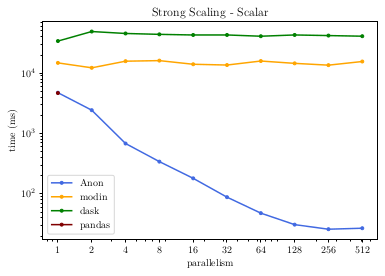

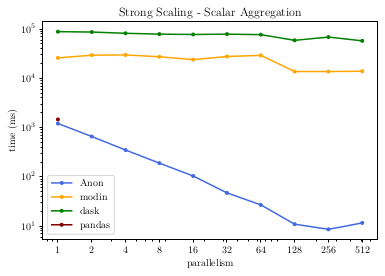

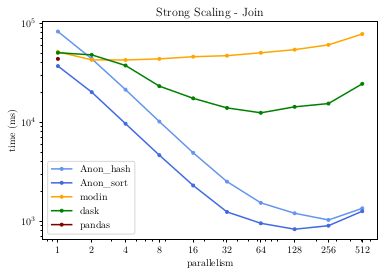

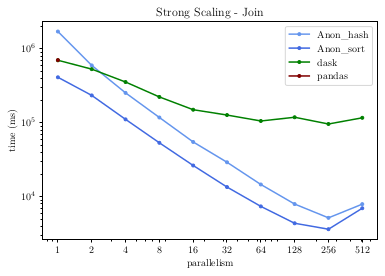

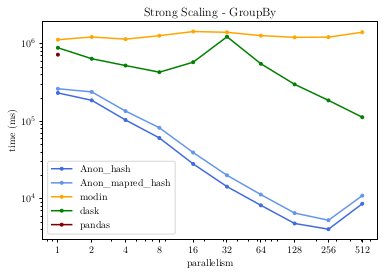

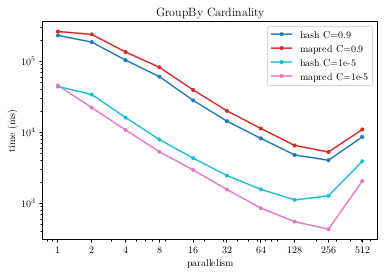

In [15]:
just_show = False

process_scalar(f'{resultsgraphs}/scalar.csv', f'{resultsgraphs}/modin_scalar.csv', f'{resultsgraphs}/dask_scalar.csv',
               f'{resultsgraphs}/pandas_scalar.csv', 'Strong Scaling - Scalar',
               f'{resultsgraphs}/scalar.pgf', 1000000000, just_show)

process_scalar(f'{resultsgraphs}/scalar-agg.csv', f'{resultsgraphs}/modin_scalar_agg.csv',
               f'{resultsgraphs}/dask_scalar_agg.csv',
               f'{resultsgraphs}/pandas_scalar_agg.csv', 'Strong Scaling - Scalar Aggregation',
               f'{resultsgraphs}/scalar-agg.pgf', 1000000000, just_show)

process_join(f'{resultsgraphs}/join.csv', f'{resultsgraphs}/modin_join.csv', f'{resultsgraphs}/dask_join.csv',
             f'{resultsgraphs}/pandas_join.csv', 'Strong Scaling - Join', f'{resultsgraphs}/join100M.pgf', 100000000, just_show)

process_join(f'{resultsgraphs}/join.csv', f'{resultsgraphs}/modin_join.csv', f'{resultsgraphs}/dask_join.csv', f'{resultsgraphs}/pandas_join.csv',
             'Strong Scaling - Join', f'{resultsgraphs}/join1B.pgf', 1000000000, just_show)

process_groupby(f'{resultsgraphs}/groupby.csv', f'{resultsgraphs}/modin_groupby.csv',
                f'{resultsgraphs}/dask_groupby.csv', f'{resultsgraphs}/pandas_groupby.csv', 
                'Strong Scaling - GroupBy', f'{resultsgraphs}/groupby.pgf',
                1000000000, just_show)


process_groupby_cylon(f'{resultsgraphs}/groupby.csv', 'GroupBy Cardinality', f'{resultsgraphs}/cylon_groupby.pgf',
                      1000000000, just_show)


In [8]:
df = pd.read_csv(f'{resultsgraphs}/op-framework.csv')
df.rows *= df.world
df
# df.groupby(by='world').mean()

,rows,world,time,optutput,opt,algo
0,1000000000,256,2949,4339088,non-opt,sort
1,1000000000,256,2921,4337839,non-opt,sort
2,1000000000,256,3119,4340701,non-opt,sort
3,1000000000,256,3005,4336666,non-opt,sort
4,1000000000,256,2605,4348227,opt,sort
...,...,...,...,...,...,...
59,1000000000,128,5006,8682163,opt,hash
60,1000000000,512,6470,2165610,opt,hash
61,1000000000,512,6774,2172356,opt,hash
62,1000000000,512,6747,2177574,opt,hash


In [9]:
res = df.pivot_table(values=['time'], index=['world', 'algo'], columns=['opt'])
res


time          
opt          non-opt       opt
world algo                    
32    hash  25205.25  20451.25
      sort  12709.00  11041.50
128   hash   7830.50   5042.75
      sort   4131.50   3489.25
256   hash   4810.75   3361.00
      sort   2998.50   2624.00
512   hash   6838.25   6621.50
      sort   5978.50   6048.75

In [10]:
ax = res.plot.bar(xlabel='(world, algo)', ylabel='time (ms)')

ax.legend(title=None, labels =['non-optimized', 'optimized'])

x_ticks = [ ",".join([str(x) for x in t]) for t in res.index.to_flat_index()]
ax.set_xticklabels(x_ticks, rotation=0)

if not just_show:
    matplotlib.use("pgf")
    matplotlib.rcParams.update({
        "pgf.texsystem": "xelatex",
        'font.family': 'serif',
        'text.usetex': True,
        'pgf.rcfonts': False,
    })
else:
    matplotlib.use(default_backend)
plt.savefig(f'{resultsgraphs}/opt.pgf')